# Model deployment with FastAPI

We'll use the [Palmer Penguins](https://github.com/allisonhorst/palmerpenguins) dataset. It's an alternative to [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set). Instead of using Iris flower measurements to predict one of three species, we'll use penguin measurements to predict one of three species.

<img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/man/figures/lter_penguins.png" width="50%" />

Artwork by [@allison_horst](https://twitter.com/allison_horst)

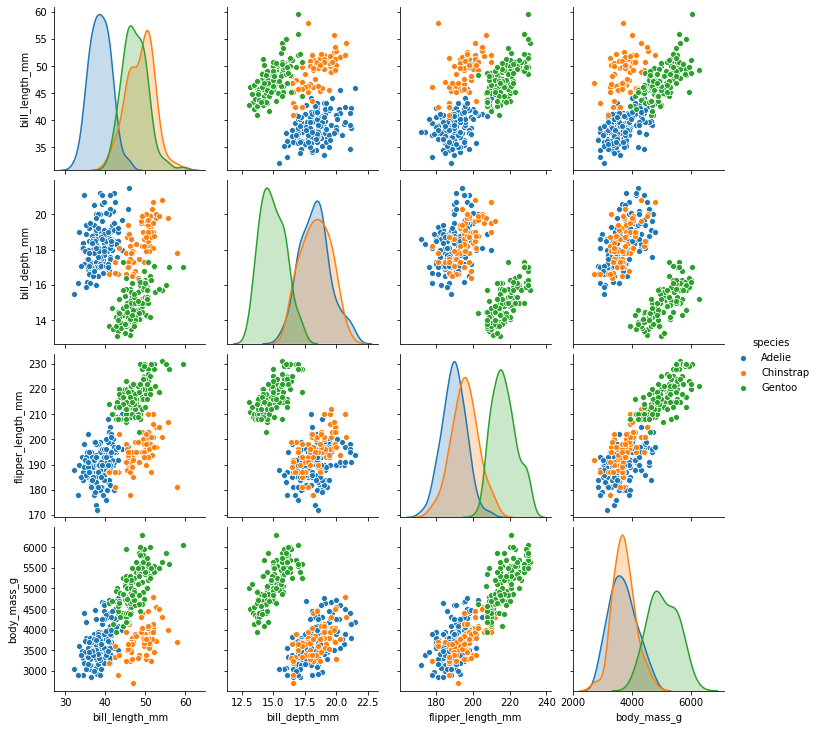

In [ ]:
import seaborn as sns
penguins = sns.load_dataset('penguins')
sns.pairplot(data=penguins, hue='species')

Looks like Adelie penguins have shorter bill length. The other two species are similar.

Gentoo penguins have less bill depth, flipper length, and body mass. The other two species are similar.

So we can classify the three species using two features: bill length and another numeric feature, such as bill depth.

<img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/man/figures/culmen_depth.png" width="50%" />

Artwork by [@allison_horst](https://twitter.com/allison_horst)

Use `bill_length_mm` and `bill_depth_mm` as features and `species` as target. Use scikit-learn to fit a Logistic Regression model. 

Scikit-learn's implementation of Logistic Regression is regularized. Use cross-validation to automate the amount of regularization. Scale the features beforehand. Combine the scaler transformation and the model into a scikit-learn pipeline. 

Use cross-validation to estimate how accurate the model generalizes.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

features = ['bill_length_mm', 'bill_depth_mm']
target = 'species'

penguins.dropna(subset=features, inplace=True)
X = penguins[features]
y = penguins[target]

classifier = make_pipeline(
    StandardScaler(), 
    LogisticRegressionCV()
)

classifier.fit(X, y)

scores = cross_val_score(classifier, X, y)
avg_acc = scores.mean() * 100
std_acc = scores.std() * 100
print(f'Cross-Validation Accuracy: {avg_acc:.0f}% +/- {2*std_acc:.0f}%')

Cross-Validation Accuracy: 96% +/- 4%


You want to deploy your scikit-learn model as an API that makes new predictions. Now what?

In [ ]:
import random

def random_penguin():
    """Return a random penguin species"""
    return random.choice(['Adelie', 'Chinstrap', 'Gentoo'])

In [ ]:
random_penguin()

'Adelie'

In [ ]:
classifier

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class='auto',
                                      n_jobs=None, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring=None, solver='lbfgs', tol=0.0001,
                                      verbose=0))],
         verbose=False)

In [ ]:
from joblib import dump
dump(classifier, 'classifier.joblib', compress=True)

['classifier.joblib']

In [ ]:
!ls -lh classifier.joblib

-rw-r--r-- 1 root root 5.2K Sep 21 19:26 classifier.joblib


In [ ]:
del classifier

In [ ]:
classifier

NameError: ignored

In [ ]:
from joblib import load
classifier = load('classifier.joblib')

In [ ]:
from google.colab import files
files.download('classifier.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.__version__

'0.16.0'

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

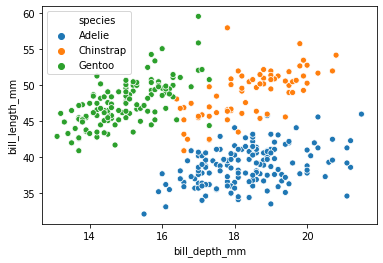

In [ ]:
sns.scatterplot(data=penguins, x='bill_depth_mm', y='bill_length_mm', hue='species')

In [ ]:
gary_gentoo = {"bill_length_mm": 45, "bill_depth_mm": 15}

How do we go from JSON / dictionary to something our model can use?

We need a Numpy array or a Pandas dataframe, with two columns (for our two features) and one row (for our one observation that we want to predict)

In [ ]:
import pandas as pd
df = pd.DataFrame([gary_gentoo])
classifier.predict(df)

array(['Gentoo'], dtype=object)

In [ ]:
amy_adelie = {"bill_length_mm": 35, "bill_depth_mm":  18}
df = pd.DataFrame([amy_adelie])
classifier.predict(df)

array(['Adelie'], dtype=object)

In [ ]:
from typing import Dict

def predict_species(penguin: Dict):
    """Predict penguin species from bill length & depth"""
    df = pd.DataFrame([penguin])
    species = classifier.predict(df)
    return species[0]

In [ ]:
predict_species(amy_adelie)

'Adelie'

In [ ]:
!pip install pydantic

     |████████████████████████████████| 8.7MB 3.4MB/s 


In [ ]:
from pydantic import BaseModel

class Penguin(BaseModel):
    bill_length_mm: float
    bill_depth_mm: float

In [ ]:
Penguin(bill_length_mm=45, bill_depth_mm=15)

Penguin(bill_length_mm=45.0, bill_depth_mm=15.0)

In [ ]:
Penguin(**gary_gentoo)

Penguin(bill_length_mm=45.0, bill_depth_mm=15.0)

In [ ]:
missing_input = {"bill_length_mm": 45}
Penguin(**missing_input)

ValidationError: ignored

In [ ]:
x = {"bill_length_mm": 45, "bill_depth_mm": "15"}
Penguin(**x)

Penguin(bill_length_mm=45.0, bill_depth_mm=15.0)

In [ ]:
wrong_type = {"bill_length_mm": 45, "bill_depth_mm": "Hello Penguins!"}
Penguin(**wrong_type)

ValidationError: ignored

In [ ]:
extra_input = {"bill_length_mm": 45, "bill_depth_mm": 15, "extra_feature": "will be ignored"}
Penguin(**extra_input)

Penguin(bill_length_mm=45.0, bill_depth_mm=15.0)

In [ ]:
flipped_order = {"bill_depth_mm": 15, "bill_length_mm": 45}
Penguin(**flipped_order)

Penguin(bill_length_mm=45.0, bill_depth_mm=15.0)

In [ ]:
from pydantic import BaseModel

class Penguin(BaseModel):
    bill_length_mm: float
    bill_depth_mm: float

    def to_df(self):
        return pd.DataFrame([dict(self)])

In [ ]:
Penguin(**gary_gentoo).to_df()

,bill_length_mm,bill_depth_mm
0,45.0,15.0


In [ ]:
from pydantic import BaseModel, confloat

class Penguin(BaseModel):
    bill_length_mm: confloat(gt=32, lt=60)
    bill_depth_mm: confloat(gt=13, lt=22)

    def to_df(self):
        return pd.DataFrame([dict(self)])

In [ ]:
huge_penguin = {"bill_depth_mm": 1500, "bill_length_mm": 4500}
Penguin(**huge_penguin)

ValidationError: ignored

In [ ]:
help(confloat)

In [ ]:
X.describe()